This notebook is intended for parsing of regulatory phrase information

# Import Packages

In [324]:
# built-in packages
from pathlib import Path
import re

# third-party packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# RegulonDB File Helpers

In [2]:
REGULONDB_PATH = Path('../data/regulondb11.1/')

In [53]:
def read_regulon_db_file(filename) -> pd.DataFrame:
    """
    Given a filename for a raw TXT file from RegulonDB, parses into a DataFrame
    :param Union[str, Path] filename: the filename of the RegulonDB TXT file to read into a pandas DataFrame
    :return pd.DataFrame regulon_df: a pandas DataFrame parsed from a RegulonDB raw TXT file
    """

    full_filename = Path(REGULONDB_PATH, filename)

    with open(full_filename, 'r') as f:
        lines = f.readlines()

    comment = True
    i = 0
    while comment:
        if lines[i].startswith('#') or lines[i].startswith(' #'):
            i += 1
        else:
            comment = False

    names = [line[5:-1].strip() for line in lines if re.match(r'# \d', line)]
    df = pd.read_csv(full_filename, index_col=None, skiprows=i, sep='\t', header=None, names=names)

    return df.drop_duplicates()

In [54]:
def to_strand_int(strand):
    if strand in ['forward', '+', 1, 'FWD']:
        return 1
    elif strand in ['reverse', '-', -1, 'REV']:
        return -1
    else:
        return None

In [55]:
DATA_OUTPUT_PATH = Path('../data/promoter_survey/')

# Regulatory Phrases

In [196]:
promoter_df = read_regulon_db_file('promoter.txt').dropna(axis='columns', how='all').drop(columns=['KEY_ID_ORG'])

reg_phrase_df = read_regulon_db_file('reg_phrase.txt')
reg_phrase_df = reg_phrase_df.dropna(axis='columns', how='all').drop(columns=['KEY_ID_ORG'])

reg_phrase_ri_link_df = read_regulon_db_file('reg_phrase_ri_link.txt')

ri_df = read_regulon_db_file('regulatory_interaction.txt')
ri_df = ri_df.dropna(axis='columns', how='all').drop(columns=['KEY_ID_ORG'])

ri_df = ri_df.merge(reg_phrase_ri_link_df, on='REGULATORY_INTERACTION_ID', how='left')
ri_df = ri_df.merge(reg_phrase_df, on='REG_PHRASE_ID', how='left')
ri_df = ri_df.merge(promoter_df, on='PROMOTER_ID', how='left')
# there's a weird row with <br> reg interaction ID that has no other info, very bizarre
ri_df = ri_df.dropna(subset='PHRASE')

## Phrase Appearances

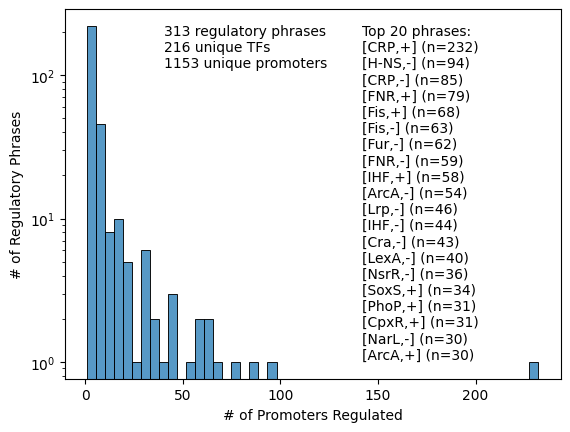

In [254]:
phrase_counts = {}
for phrase in ri_df['PHRASE'].unique():
    phrase_counts[phrase] = ri_df[ri_df['PHRASE'] == phrase]['PROMOTER_ID'].nunique()
phrase_counts = pd.Series(phrase_counts).sort_values(ascending=False)

_, ax = plt.subplots()

sns.histplot(phrase_counts.values, ax=ax, bins=50)
ax.set_yscale('log')
ax.set_xlabel('# of Promoters Regulated')
ax.set_ylabel('# of Regulatory Phrases')

n_unique_tfs = len(set([re.split(r',(\+|\-|\?)\]', phrase)[0][1:] for phrase in phrase_counts.index]))
n_promoters = ri_df['PROMOTER_ID'].nunique()
ax.text(0.2, 0.96, f'{phrase_counts.shape[0]} regulatory phrases\n{n_unique_tfs} unique TFs\n{n_promoters} unique promoters', transform=ax.transAxes, va='top')

top_n = 20
top_n_text = "\n".join([f"{idx} (n={val})" for idx, val in phrase_counts[:top_n].items()])
ax.text(0.6, 0.96, f"Top {top_n} phrases:\n{top_n_text}", transform=ax.transAxes, va='top');

## Phrases by Promoter

Note that the crlP1 promoter name is repeated for 2 distinct promoter IDs for some reason

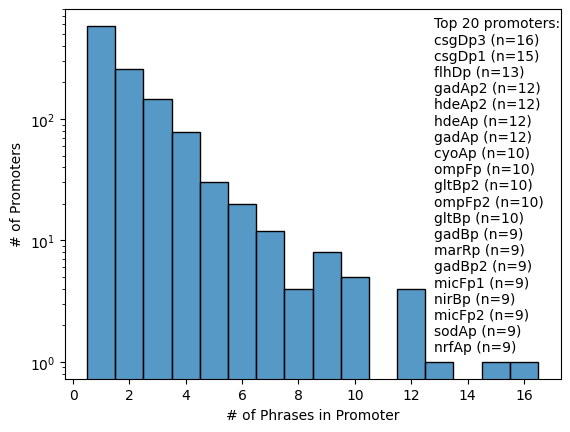

In [332]:
phrases_per_promoter = {}
pid_to_name = {}
for pid, pid_df in ri_df.groupby('PROMOTER_ID'):
    phrases_per_promoter[pid] = pid_df['PHRASE'].nunique()
    # assumes that each promoter ID only has one corresponding name
    pid_to_name[pid] = pid_df['PROMOTER_NAME'].unique()[0]

phrases_per_promoter = pd.Series(phrases_per_promoter).sort_values(ascending=False)

_, ax = plt.subplots()

sns.histplot(phrases_per_promoter.values, ax=ax, discrete=True)
ax.set_yscale('log')
ax.set_xlabel('# of Phrases in Promoter')
ax.set_ylabel('# of Promoters')

top_n = 20
top_n_text = "\n".join([f"{pid_to_name[idx]} (n={val})" for idx, val in phrases_per_promoter[:top_n].items()])
ax.text(0.745, 0.98, f"Top {top_n} promoters:\n{top_n_text}", transform=ax.transAxes, va='top');

## TFBS per Phrase

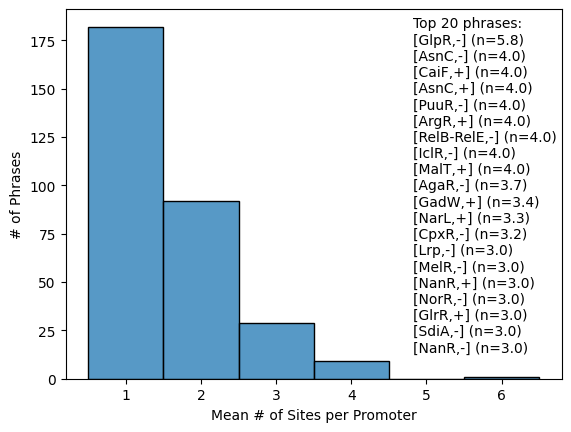

In [334]:
phrase_to_n_sites = {}

for (pid, phrase), pid_phrase_df in ri_df.groupby(['PROMOTER_ID', 'PHRASE']):
    if phrase in phrase_to_n_sites:
        phrase_to_n_sites[phrase].append(pid_phrase_df['SITE_ID'].nunique())
    else:
        phrase_to_n_sites[phrase] = [pid_phrase_df['SITE_ID'].nunique()]
        
phrase_to_med_n_sites = pd.Series({k: np.mean(v) for k, v in phrase_to_n_sites.items()}).sort_values(ascending=False)

_, ax = plt.subplots()

sns.histplot(phrase_to_med_n_sites.values, ax=ax, discrete=True)
ax.set_xlabel('Mean # of Sites per Promoter')
ax.set_ylabel('# of Phrases')

top_n = 20
top_n_text = "\n".join([f"{idx} (n={val:.1f})" for idx, val in phrase_to_med_n_sites[:top_n].items()])
ax.text(0.7, 0.98, f"Top {top_n} phrases:\n{top_n_text}", transform=ax.transAxes, va='top');

## Phrase Co-Occurrence

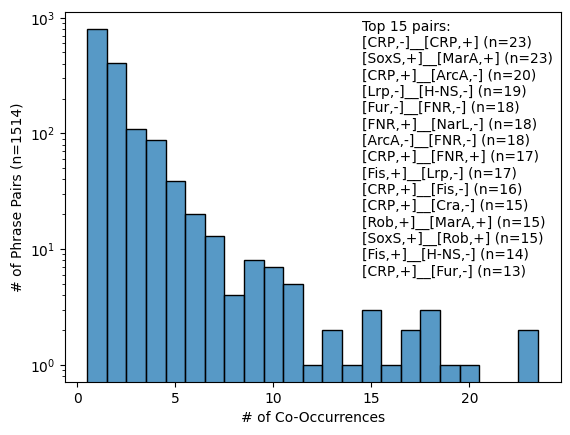

In [323]:
pid_phrase_binary_rows = []
for pid, pid_df in ri_df.groupby('PROMOTER_ID'):
    pid_phrase_binary_rows.append({phrase: 1 for phrase in pid_df['PHRASE'].unique()})
    
pid_phrase_binary = pd.DataFrame(pid_phrase_binary_rows)
pid_phrase_binary = pid_phrase_binary.fillna(0).astype(int)

phrase_cooccur = pid_phrase_binary.T.dot(pid_phrase_binary)
np.fill_diagonal(phrase_cooccur.values, 0)
phrase_cooccur = pd.DataFrame(np.triu(phrase_cooccur), index=phrase_cooccur.index, columns=phrase_cooccur.columns)
non_zero_cooccur = phrase_cooccur.stack()[phrase_cooccur.stack() != 0].reset_index()
non_zero_cooccur = non_zero_cooccur.assign(
    new_index=(non_zero_cooccur['level_0'] + "__" + non_zero_cooccur['level_1'])
)
non_zero_cooccur = non_zero_cooccur.set_index("new_index").drop(columns=['level_0', 'level_1']).iloc[:, 0].sort_values(ascending=False)

_, ax = plt.subplots()

sns.histplot(non_zero_cooccur.values, ax=ax, discrete=True)
ax.set_yscale('log')
ax.set_xlabel('# of Co-Occurrences')
ax.set_ylabel(f'# of Phrase Pairs (n={non_zero_cooccur.shape[0]})')

top_n = 15
top_n_text = "\n".join([f"{idx} (n={val})" for idx, val in non_zero_cooccur[:top_n].items()])
ax.text(0.6, 0.98, f"Top {top_n} pairs:\n{top_n_text}", transform=ax.transAxes, va='top');